In [1]:
from pathlib import Path
import xarray as xr

import sys

sys.path.append(str(Path("../src").resolve()))

import torch
import torch.nn.functional
from torch.utils.data import DataLoader
from climanet.st_encoder_decoder import (
    SpatioTemporalModel,
    pred_to_numpy,
)

from climanet import STDataset

## Read data

In [2]:
data_folder = Path("../../data/output/")

file_name = data_folder / "202001_day_ERA5_masked_ts.nc"
daily_data = xr.open_dataset(file_name)

file_name = data_folder / "202001_mon_ERA5_full_ts.nc"
monthly_data = xr.open_dataset(file_name)

# downloded from era5 and regridded using the function `regrid_to_boundary_centered_grid`
# land 1, ocean 0
file_name = data_folder / "era5_lsm_bool.nc"
lsm_mask = xr.open_dataset(file_name)

## Subset data (for fast example)

In [3]:
# coordinates of subset
lon_subset = slice(-50, -30)
lat_subset = slice(-40, -20)

daily_subset = daily_data.sel(lon=lon_subset, lat=lat_subset)
monthly_subset = monthly_data.sel(lon=lon_subset, lat=lat_subset)
lsm_subset = lsm_mask.sel(longitude=lon_subset, latitude=lat_subset)
# rename dimensions to match the expected names in the dataset
lsm_subset = lsm_subset.rename({"longitude": "lon", "latitude": "lat"})

In [4]:
daily_subset

<xarray.Dataset> Size: 795kB
Dimensions:    (time: 31, bnds: 2, lat: 80, lon: 80)
Coordinates:
  * time       (time) datetime64[ns] 248B 2020-01-01T11:30:00 ... 2020-01-31T...
  * lat        (lat) float32 320B -39.88 -39.62 -39.38 ... -20.62 -20.38 -20.12
  * lon        (lon) float32 320B -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 496B ...
    ts         (time, lat, lon) float32 794kB ...
Attributes:
    CDI:          Climate Data Interface version 2.2.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Oct 31 09:28:31 2025: cdo daymean 202001_ERA5_masked_ts...
    frequency:    day
    CDO:          Climate Data Operators version 2.2.2 (https://mpimet.mpg.de...

In [5]:
monthly_subset

<xarray.Dataset> Size: 26kB
Dimensions:    (time: 1, bnds: 2, lat: 80, lon: 80)
Coordinates:
  * time       (time) datetime64[ns] 8B 2020-01-16T11:30:00
  * lat        (lat) float32 320B -39.88 -39.62 -39.38 ... -20.62 -20.38 -20.12
  * lon        (lon) float32 320B -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 16B ...
    ts         (time, lat, lon) float32 26kB ...
Attributes:
    CDI:          Climate Data Interface version 2.2.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Oct 31 09:31:04 2025: cdo timmean 202001_ERA5_full_ts.n...
    CDO:          Climate Data Operators version 2.2.2 (https://mpimet.mpg.de...

## Create the model

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SpatioTemporalModel(embed_dim=128, patch_size=(1, 16, 16), overlap=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
decoder = model.decoder

with torch.no_grad():
    decoder.bias.fill_(monthly_subset["ts"].values.mean())
    decoder.scale.fill_(
        monthly_subset["ts"].values.std() + 1e-6
    )  # small epsilon to avoid zero

In [7]:
dataset = STDataset(
    daily_da=daily_subset["ts"],
    monthly_da=monthly_subset["ts"],
    land_mask=lsm_subset["lsm"],
    patch_size=(16, 16),
    overlap=2,
)

## Train the model

In [8]:
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    pin_memory=False,
)

In [9]:
best_loss = float("inf")
patience = 10  # stop if no improvement for <patience> epochs
counter = 0

# Training loop with DataLoader
model.train()
for epoch in range(101):
    for batch in dataloader:
        # Initialize gradients
        optimizer.zero_grad()

        # Get batch data
        daily_batch = batch["daily_patch"]
        daily_mask = batch["daily_mask_patch"]
        monthly_target = batch["monthly_patch"]
        land_mask = batch["land_mask_patch"][0, ...]  # same for all batches

        # Batch prediction
        pred = model(daily_batch, daily_mask, land_mask)
        # Compute loss
        ocean = ~land_mask
        ocean_broadcasted = ocean.unsqueeze(0)  # [1,H,W]

        loss = torch.nn.functional.l1_loss(
            pred * ocean, monthly_target * ocean, reduction="sum"
        )  # For SST there is only one channel
        loss = loss / ocean_broadcasted.sum()
        loss.backward()
        optimizer.step()

    # Early stopping check
    if loss.item() < best_loss:
        best_loss = loss.item()
        counter = 0  # reset counter if improved
    if epoch % 20 == 0:
        print(f"The loss is {best_loss} at epoch {epoch}")
    else:
        counter += 1
        if counter >= patience:
            print(
                f"No improvement for {patience} epochs, stopping early at epoch {epoch}."
            )
            break

print("training done!")
print(loss.item())

The loss is 30.19863510131836 at epoch 0
The loss is 6.372329235076904 at epoch 20
No improvement for 10 epochs, stopping early at epoch 29.
training done!
10.819591522216797


## Inspect results and compare

In [10]:
dataset_pred = STDataset(
    daily_da=daily_subset["ts"],
    monthly_da=monthly_subset["ts"],
    land_mask=lsm_subset["lsm"],
    patch_size=(daily_subset.sizes["lat"], daily_subset.sizes["lon"]),
)
dataloader_pred = DataLoader(
    dataset_pred,
    batch_size=len(dataset_pred),
    pin_memory=False,
)
full_batch = next(iter(dataloader_pred))

daily_batch = full_batch["daily_patch"]
daily_mask = full_batch["daily_mask_patch"]
monthly_target = full_batch["monthly_patch"]
land_mask = full_batch["land_mask_patch"][0, ...]  # same for all batches
print(daily_batch.shape, daily_mask.shape, monthly_target.shape, land_mask.shape)

torch.Size([1, 1, 31, 80, 80]) torch.Size([1, 1, 31, 80, 80]) torch.Size([1, 80, 80]) torch.Size([80, 80])


In [11]:
model.eval()
with torch.no_grad():
    pred = model(daily_batch, daily_mask, land_mask)

monthly_prediction = pred_to_numpy(pred, land_mask=land_mask)

In [12]:
monthly_subset["ts_pred"] = (
    ("time", "lat", "lon"),
    monthly_prediction,  # remove batch dimensions
)

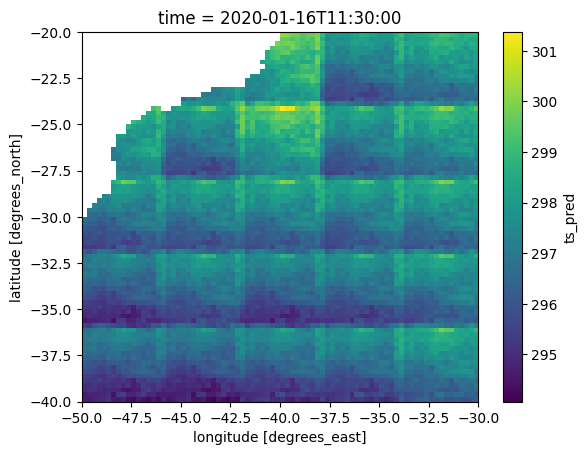

In [13]:
monthly_subset["ts_pred"].plot()

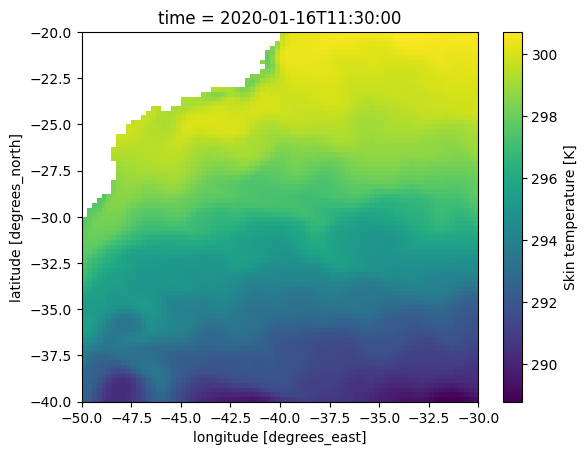

In [14]:
# original target
monthly_subset["ts"].where(~lsm_subset["lsm"].values).plot()

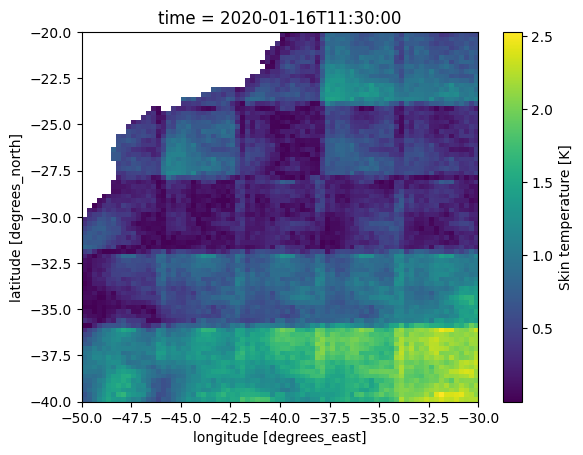

In [15]:
# Mean Absolute Error
target = monthly_subset["ts"].where(~lsm_subset["lsm"].values)
rmae = abs(target - monthly_subset["ts_pred"]) / target.std(skipna=True)
rmae.plot()

## Save the output

In [16]:
# Save the trained model
model_save_path = Path("./models/spatio_temporal_model.pth")
model_save_path.parent.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), model_save_path)

In [17]:
# Save the xr.Dataset with predictions
predictions_save_path = Path("./predicted_data/predictions.nc")
predictions_save_path.parent.mkdir(parents=True, exist_ok=True)
monthly_subset.to_netcdf(predictions_save_path)